### Survival Curve or Kaplan Meier Curve

What is __Suvival Analysis__? 
It is actually a set of techniques that helps us understand the relationship between the time and events whether the subjects (e.g. customers, etc.) would quit, start paying, etc. It also helps us understand what would make such event to occur at any given time. (e.g. Age, Ethnicity, Diet, etc).

If your goal is to predict who is going to quit (churn) your service or not, then you could use some technique like Logistic Regression, which is useful to predict a binary outcome, like Retain or Churn. But typically in the retention analysis case, what we really want to understand is, how the retention rates change over a period of time. So when you want to predict or understand not just when the customers will quit, but also when or how the probability of the ‘quit’ changes over time, you want to consider using Survival Analysis.

__Survival Curve__ is to show you the estimates of how the retention/churn rates change over time and how the trend differs among ‘cohorts’. For example, you might want to understand how the trend of retention rate differs between users from US and Japan or the users who joined in January and February.

In order to analyze the customer retention or churn even further, __Survival Model__ (i.e. Cox Regression) focuses on the relationship between the time to event and the variables.

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches #for custom legends
import seaborn as sns
from lifelines import KaplanMeierFitter #survival analysis library
from lifelines.statistics import logrank_test #survival statistical testing
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

In [6]:
url="https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Telco-Customer-Churn.csv?cm_mc_uid=51304980933215218170416&cm_mc_sid_50200000=92178841521817041648&cm_mc_sid_52640000=98592221521817041652"

In [7]:
df = pd.read_csv(url)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)

In [9]:
display_all(df.tail().transpose())

,7038,7039,7040,7041,7042
customerID,6840-RESVB,2234-XADUH,4801-JZAZL,8361-LTMKD,3186-AJIEK
gender,Male,Female,Female,Male,Male
SeniorCitizen,0,0,0,1,0
Partner,Yes,Yes,Yes,Yes,No
Dependents,Yes,Yes,Yes,No,No
tenure,24,72,11,4,66
PhoneService,Yes,Yes,No,Yes,Yes
MultipleLines,Yes,Yes,No phone service,Yes,No
InternetService,DSL,Fiber optic,DSL,Fiber optic,Fiber optic
OnlineSecurity,Yes,No,Yes,No,Yes


In [11]:
df["churn"] = df.Churn.apply(lambda x: 1 if x == "Yes" else 0) #recode churn var

In [12]:
df["churn"].value_counts()

0    5174
1    1869
Name: churn, dtype: int64

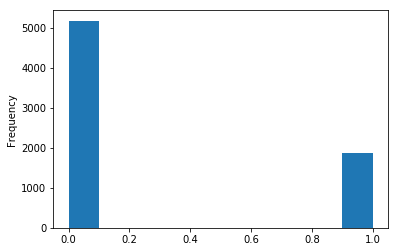

In [13]:
df['churn'].astype(int).plot.hist()

In [14]:
#drop "No phone service"
df[df.MultipleLines != "No phone service"]

#recode MultipleLines var to get our two comparison cohorts
df["MultipleLines"] = df.MultipleLines.apply(lambda x: 1 if x == "Yes" else 0)

In [15]:
#this is not time series data, so we will assume all customers start at t = 0 
# and continue until t = tenure
df.tenure.describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

### Kaplan-Meier Curve

This will allow us to estimate the “survival function” of one or more cohorts, and it is one of the most common statistical techniques used in survival analysis.

In [16]:
kmf = KaplanMeierFitter()
T = df['tenure'] #duration
C = df["churn"] #censorship - 1 if churn is seen, 0 if censored

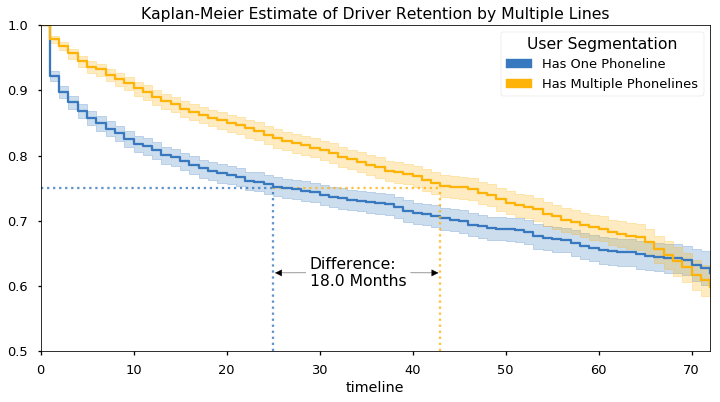

In [19]:
palette = ["windows blue", "amber"]
sns.set_palette(sns.xkcd_palette(palette))

##SET UP PLOT
ax = plt.subplot(111)
plt.title('Kaplan-Meier Estimate of Driver Retention by Multiple Lines')
sns.set_context("talk")

d={} #to store the models
vlines = []
i=0
##PLOT FITTED GRAPH
#loop through segmentation variable, plot on same axes
#Multiple groups
for segment in df.MultipleLines.unique(): 
    ix = df.MultipleLines == segment
    d['kmf{}'.format(i+1)] = kmf.fit(T.loc[ix],C.loc[ix], label=segment)
    ax = kmf.plot(ax=ax, figsize=(12,6))

    ax.set_xlim([T.min(),T.max()])
    ax.set_ylim([0.5,1])
#After calling the fit method, we have access to new properties like survival_function_ and methods like plot().  
    y_ = kmf.survival_function_[kmf.survival_function_.round(2) ==.75].dropna().index[0]
    ymax_ = kmf.survival_function_[kmf.survival_function_.round(2) ==.75].dropna()[i][y_]
    
    vlines.append([y_, ymax_])
    i+=1

##PLOT ANNOTATION
#for each intercept, plot a horizontal and a vertical line up to the fitted curve
xmin_=0
for i, xy in enumerate(vlines):
    xmax_ = xy[0]
    color="xkcd:{}".format(palette[i])
    
    plt.axvline(x=xy[0], ymax=.5, alpha=.8, color=color, linestyle='dotted') #axes fractional
    plt.hlines(y=.75, xmin=xmin_, xmax=xmax_, alpha=.8, color=color, linestyle='dotted') #axes data coordinates
    xmin_ += xmax_ #to avoid overlapping hlines

## position text label
difference = vlines[1][0]-vlines[0][0]
label_frac_x = (vlines[0][0]+(difference)/2)/T.max()-.07 #midpoint (minus .07 centering factor)
label_frac_y = 0.2

#label first line
ax.annotate('Difference:\n{} Months'.format(difference), 
  xy=(vlines[0][0],.62), xycoords='data', color='white',
  xytext=(label_frac_x,label_frac_y), textcoords='axes fraction',
  arrowprops=dict(arrowstyle="-|>", #arrows removed for reability
                  fc="k", ec="k")
           )

#label second line    
ax.annotate('Difference:\n{} Months'.format(difference), 
      xy=(vlines[1][0],.62), xycoords='data', color='black',
      xytext=(label_frac_x, label_frac_y), textcoords='axes fraction',
      arrowprops=dict(arrowstyle="-|>", #arrows removed for reability
                      fc="k", ec='k')
           )

##LEGEND
#override default legend
patches = [ mpatches.Patch(color="xkcd:windows blue", label='Has One Phoneline'),
            mpatches.Patch(color="xkcd:amber", label='Has Multiple Phonelines')
          ]
plt.legend(handles=[patches[0],patches[1]], title="User Segmentation", loc='best');

Or use the Wrapper around Panda’s internal plotting library, which is more simpler

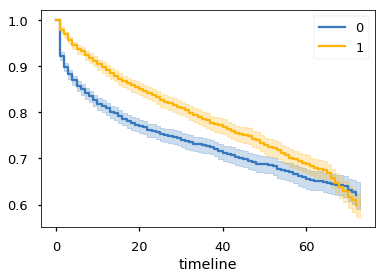

In [25]:
groups = df['MultipleLines']
ix = (groups == 1)

kmf.fit(T[~ix], C[~ix], label='0')
ax = kmf.plot()

kmf.fit(T[ix], C[ix], label='1')
kmf.plot(ax=ax)

The x axis is ‘time’ column that represents the time period. In this example, we used ‘weeks_on_service’ column as the survival time, so the time here means the N-th week. And the y axis  is  ‘estimate’ value that representing the percentage of the users who are retained by this particular point of time for each week. 

Reminder:

Churn=1-Retention 

We can see a cohort of ‘1’ - multiple line  users showing a bit smoother curve, which means it’s better than ‘0’-one line users in terms of the retention rate trend, though the difference is shrinking as the time goes by.

In [21]:
multi = (df["MultipleLines"] == 1)
results = logrank_test(T[multi], T[~multi], C[multi], C[~multi], alpha=0.99 ) #at 99% confidence level
results.print_summary()


t_0=-1, alpha=0.99, null_distribution=chi squared, df=1

test_statistic      p     
       24.8504 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [22]:
Z = results.test_statistic
D = C.sum() #number of events observed

hazard_ratio = np.exp(Z*np.sqrt(4/D))
print(hazard_ratio)

3.157035574094717
